In [1]:
import pandas as pd
import ast
import os
import glob
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
experiments_csv_folder = "./experiments_output_csv"
merged_result_filename = "./merged_csv/experiments_result.csv"

# Parsing

In [3]:
def load_and_parse_metrics(csv_folder):
    """
    Load all experiment metric CSVs and parse best_hyperparameters into structured columns.
    Safely handles files with duplicate column names.
    """
    all_dataframes = []
    for file_path in glob.glob(os.path.join(csv_folder, f"*.csv")):
        dataset_name = os.path.splitext(os.path.basename(file_path))[0]
        df = pd.read_csv(file_path, mangle_dupe_cols=True)
        df["dataset"] = dataset_name
        df["parsed_params"] = df["best_hyperparameters"].apply(ast.literal_eval)
        params_df = df["parsed_params"].apply(pd.Series)
        df_final = pd.concat([df.drop(columns=["parsed_params"]), params_df], axis=1)
        all_dataframes.append(df_final)
    return pd.concat(all_dataframes, ignore_index=True)


In [4]:
def extract_model_config(model_name):
    """
    Extracts attack_only and train_percentage from model_name.
    """
    match = re.search(r'SupervisedGMM(_AttackOnly)?_(\d+)%', model_name)
    if match:
        attack_only = match.group(1) is not None
        train_percentage = int(match.group(2))
        return pd.Series([attack_only, train_percentage])
    else:
        return pd.Series([None, None])

In [5]:
# Load and parse everything
df_clean = load_and_parse_metrics(experiments_csv_folder)
df_clean[["attack_only", "train_percentage"]] = df_clean["model_name"].apply(extract_model_config)
df_clean = df_clean[["dataset", "attack_only", "train_percentage", "n_components", "covariance_type", "reg_covar", "tune_components", "selection_metric", "accuracy", "precision", "recall", "f1_score"]]

C:\Users\crist\AppData\Local\Temp\ipykernel_14292\2698169701.py:9: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  df = pd.read_csv(file_path, mangle_dupe_cols=True)
C:\Users\crist\AppData\Local\Temp\ipykernel_14292\2698169701.py:9: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  df = pd.read_csv(file_path, mangle_dupe_cols=True)
C:\Users\crist\AppData\Local\Temp\ipykernel_14292\2698169701.py:9: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  df = pd.read_csv(file_path, mangle_dupe_cols=True)
C:\Users\crist\AppData\Local\Temp\ipykernel_14292\2698169701.py:9: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. P

In [6]:
df_clean

,dataset,attack_only,train_percentage,n_components,covariance_type,reg_covar,tune_components,selection_metric,accuracy,precision,recall,f1_score
0,CIC-IDS2017,True,1,1,full,1.000000e-09,True,aic,0.987944,0.986206,0.922017,0.951698
1,CIC-IDS2017,True,1,2,full,1.000000e-09,True,accuracy,0.992558,0.974073,0.950822,0.960924
2,CIC-IDS2017,True,1,2,full,1.000000e-09,True,f1_score,0.992558,0.974073,0.950822,0.960924
3,CIC-IDS2017,True,1,3,full,1.000000e-09,False,aic,0.991920,0.973311,0.945714,0.957690
4,CIC-IDS2017,True,1,1,full,1.000000e-06,True,aic,0.991856,0.986065,0.946565,0.964961
...,...,...,...,...,...,...,...,...,...,...,...,...
1435,UNSW-NB15,True,100,3,diag,1.000000e-06,False,aic,0.474575,0.482466,0.527947,0.444343
1436,UNSW-NB15,True,100,3,diag,1.000000e-03,True,aic,0.511996,0.524072,0.552879,0.495955
1437,UNSW-NB15,True,100,2,diag,1.000000e-03,True,accuracy,0.582570,0.579118,0.576122,0.541701
1438,UNSW-NB15,True,100,2,diag,1.000000e-03,True,f1_score,0.582570,0.579118,0.576122,0.541701


In [7]:
df_clean.to_csv(merged_result_filename, index=False)

In [8]:
print(df_clean["dataset"].value_counts())

CIC-IDS2017        288
CSE-CIC-IDS2018    288
LYCOS-IDS2017      288
NSL-KDD            288
UNSW-NB15          288
Name: dataset, dtype: int64


# Plots

In [9]:
# Compute average metrics per (dataset, train_percentage)
grouped = df_clean.groupby(["dataset", "train_percentage"])[
    ["accuracy", "precision", "recall", "f1_score"]
].mean().reset_index()

In [10]:
# Plot settings
sns.set(style="whitegrid", palette="colorblind", font_scale=1.2)
train_pct_order = sorted(df_clean["train_percentage"].unique())
metrics = ["accuracy", "precision", "recall", "f1_score"]

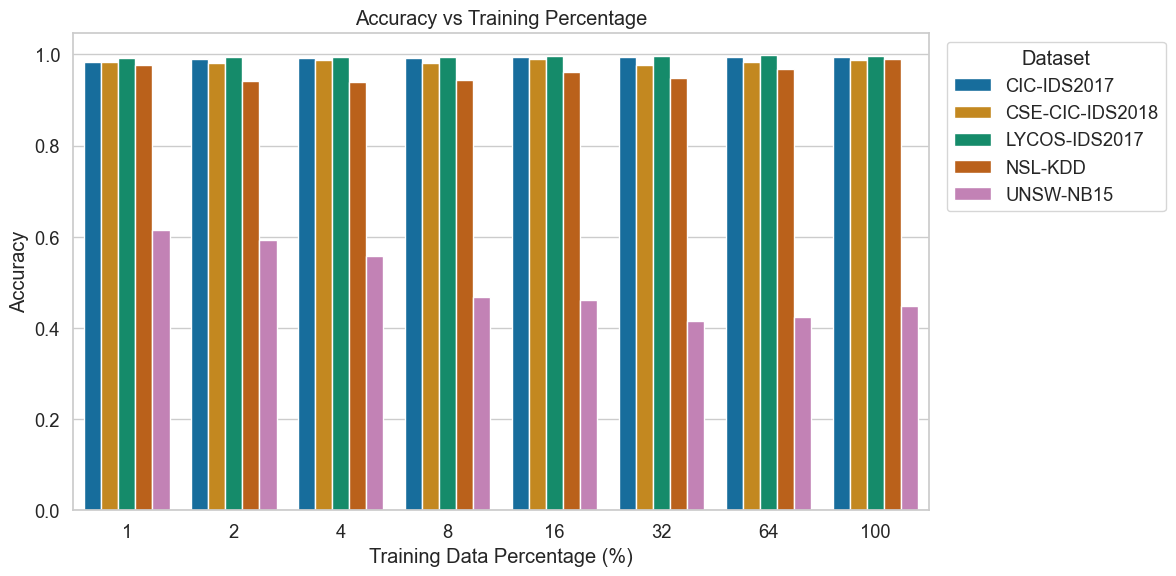

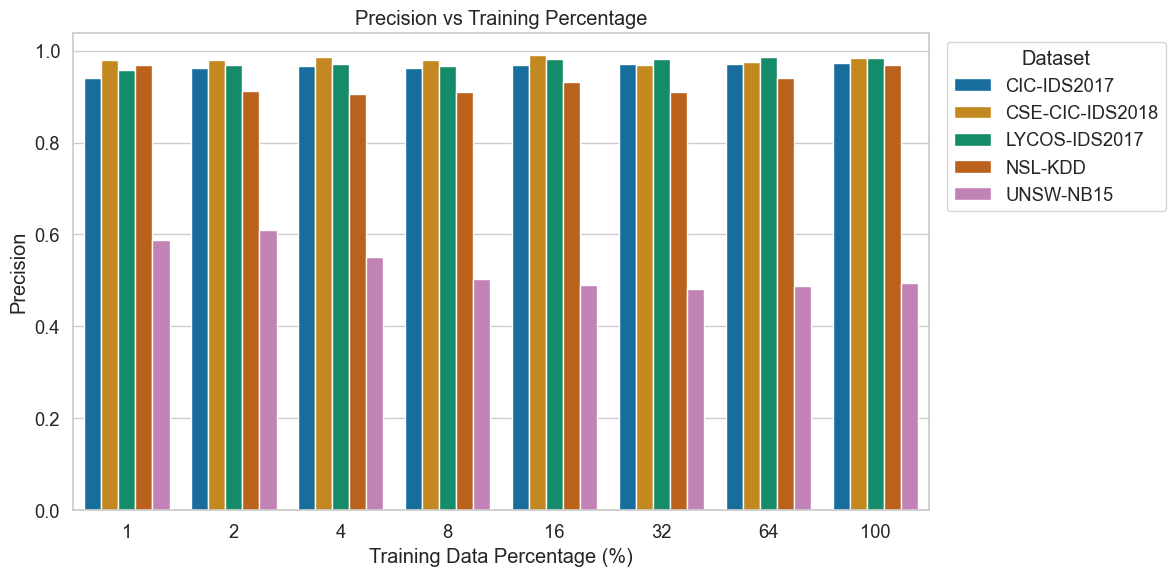

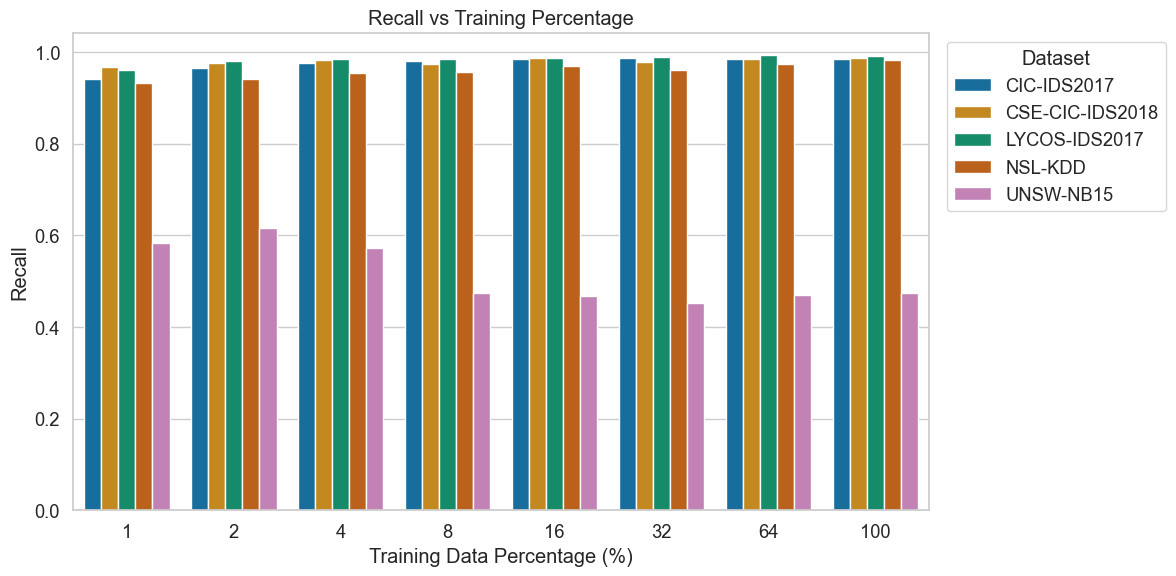

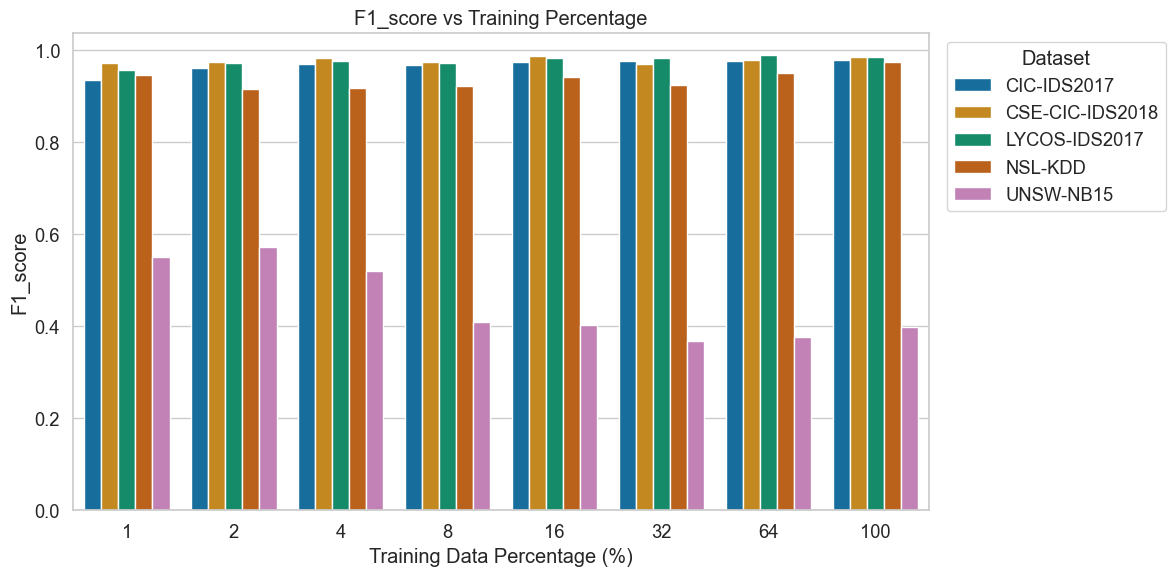

In [11]:
# Generate a grouped barplot per metric
for metric in metrics:
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=grouped,
        x="train_percentage",
        y=metric,
        hue="dataset",
        order=train_pct_order
    )
    plt.title(f"{metric.capitalize()} vs Training Percentage")
    plt.xlabel("Training Data Percentage (%)")
    plt.ylabel(metric.capitalize())
    plt.legend(title="Dataset", bbox_to_anchor=(1.01, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

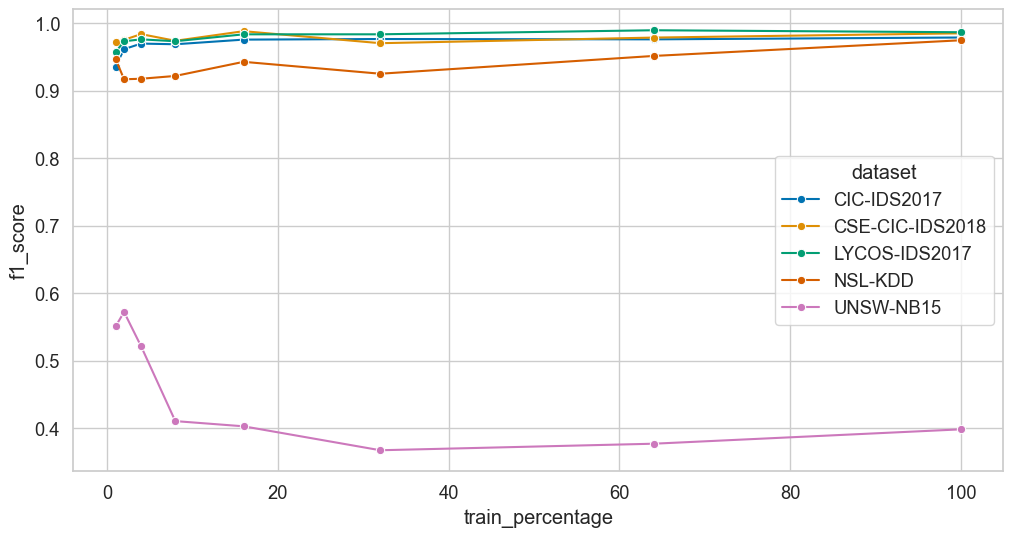

In [12]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped, x="train_percentage", y=metric, hue="dataset", marker="o");

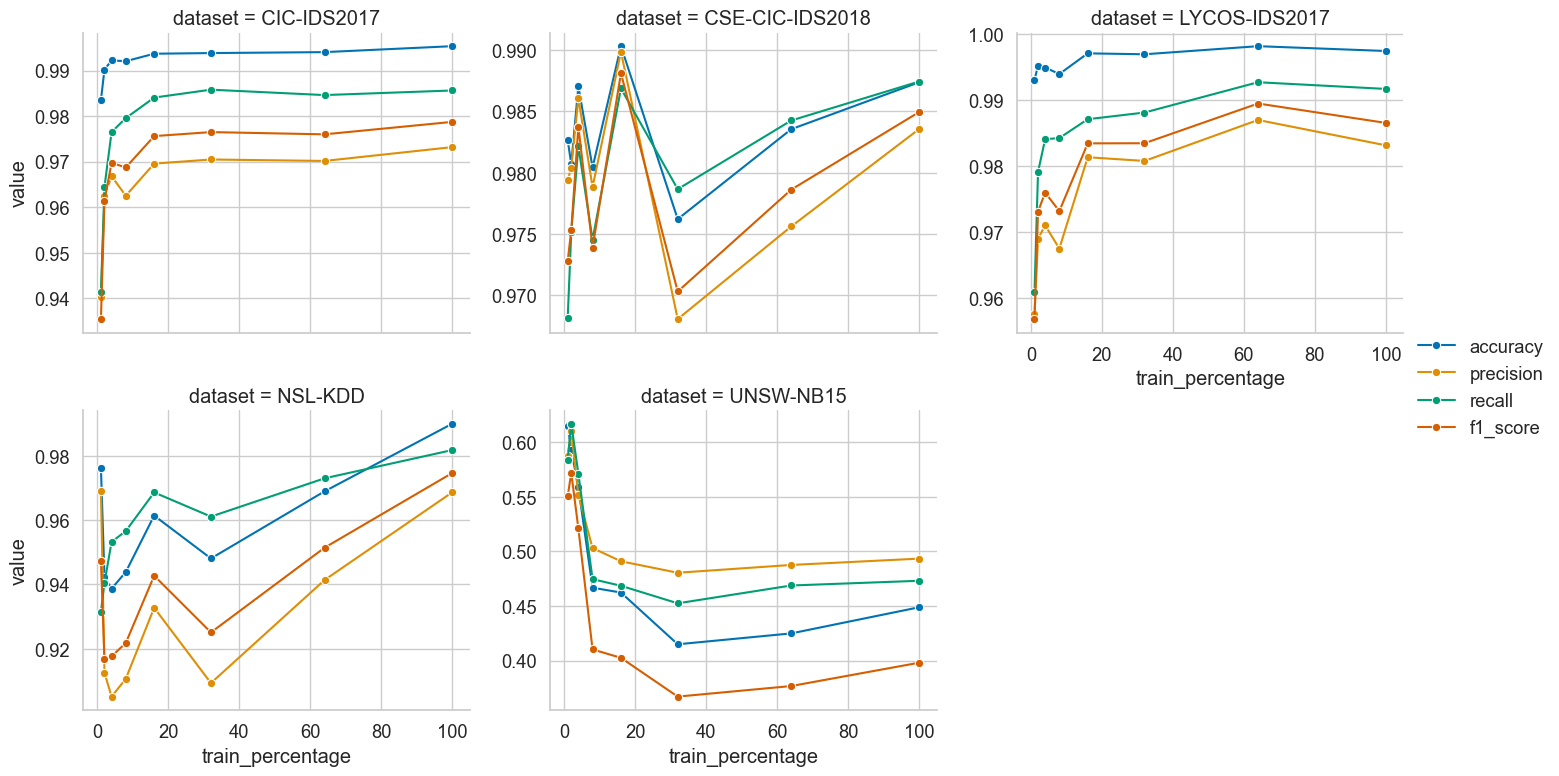

In [13]:
g = sns.FacetGrid(grouped.melt(id_vars=["dataset", "train_percentage"]), 
                  col="dataset", col_wrap=3, sharey=False, height=4, aspect=1.2)
g.map_dataframe(sns.lineplot, x="train_percentage", y="value", hue="variable", marker="o")
g.add_legend();

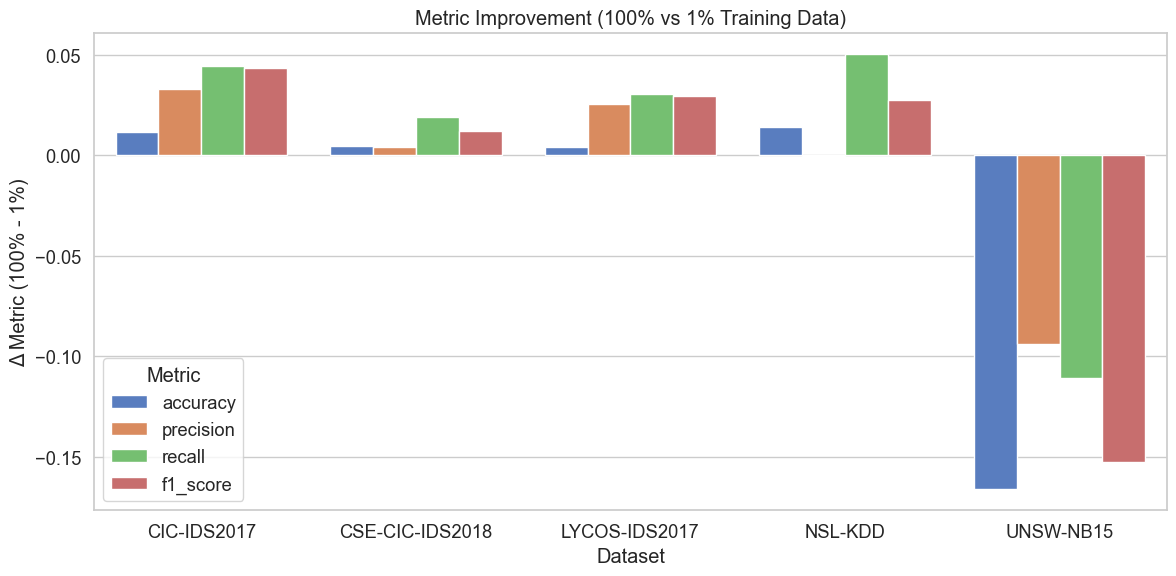

In [14]:
# Compute performance gain from 1% to 100% training data
metric_deltas = {}

# Pivot to get [dataset, metric] -> [value at 100% - value at 1%]
for metric in metrics:
    pivot = df_clean.groupby(["dataset", "train_percentage"])[metric].mean().unstack()
    metric_deltas[metric] = pivot[100] - pivot[1]

# Build a DataFrame with the results
delta_df = pd.DataFrame(metric_deltas).reset_index()
delta_df = delta_df.melt(id_vars="dataset", var_name="metric", value_name="delta")

# Plotting
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
plt.figure(figsize=(12, 6))
sns.barplot(data=delta_df, x="dataset", y="delta", hue="metric")
plt.title("Metric Improvement (100% vs 1% Training Data)")
plt.ylabel("Δ Metric (100% - 1%)")
plt.xlabel("Dataset")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

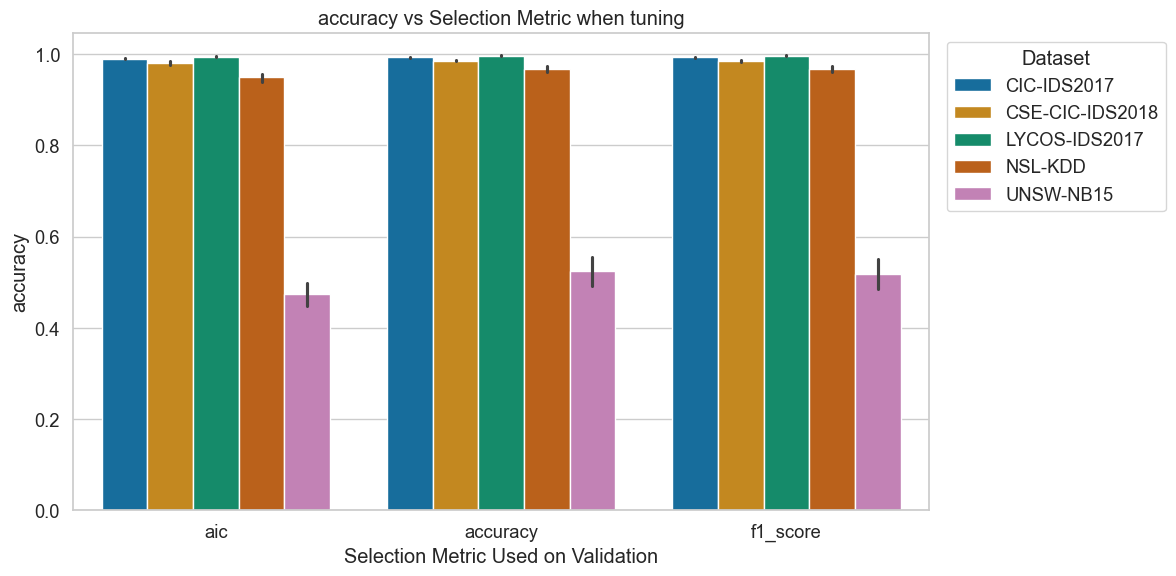

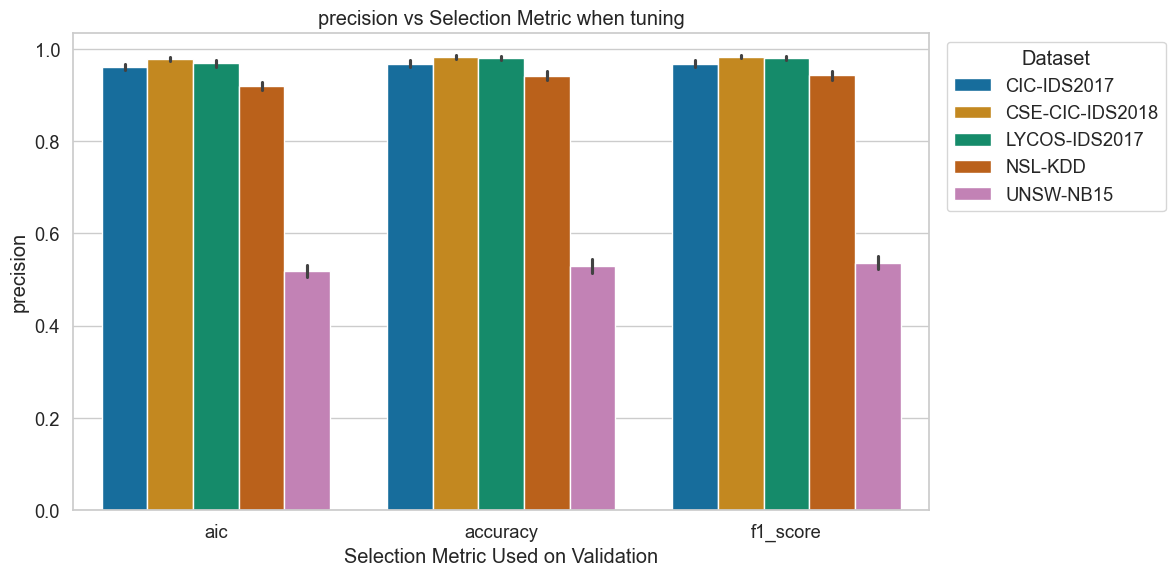

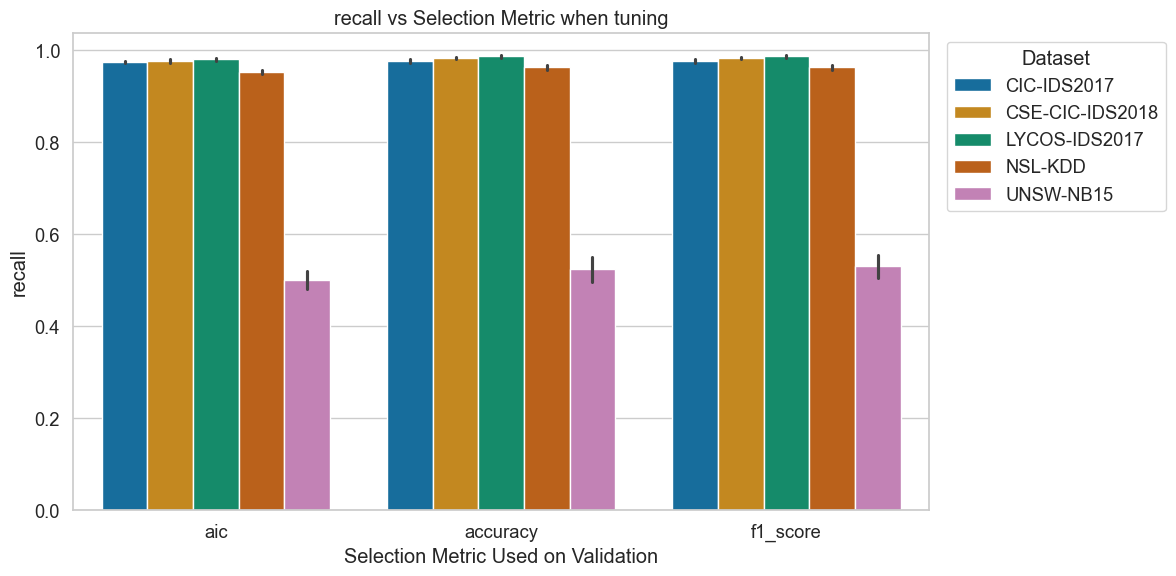

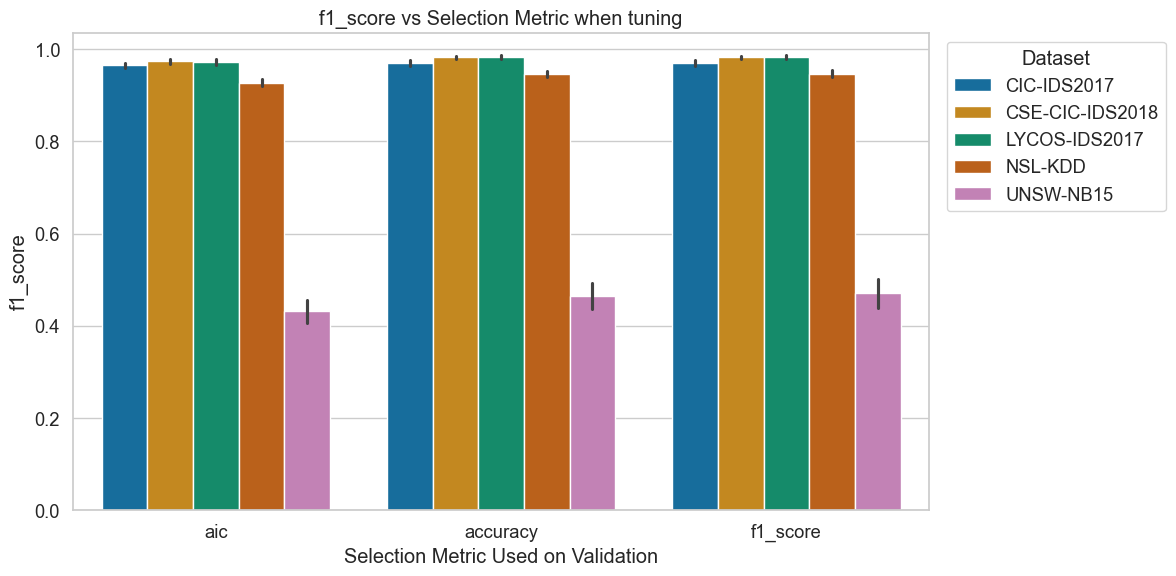

In [23]:
df_tuning = df_clean[df_clean["tune_components"] == True]

for metric in metrics:
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_clean, x="selection_metric", y=metric, hue="dataset", errorbar=('ci', 95))
    plt.title(f"{metric} vs Selection Metric when tuning")
    plt.xlabel("Selection Metric Used on Validation")
    plt.ylabel(metric)
    plt.legend(title="Dataset", bbox_to_anchor=(1.01, 1))
    plt.tight_layout()
    plt.show()

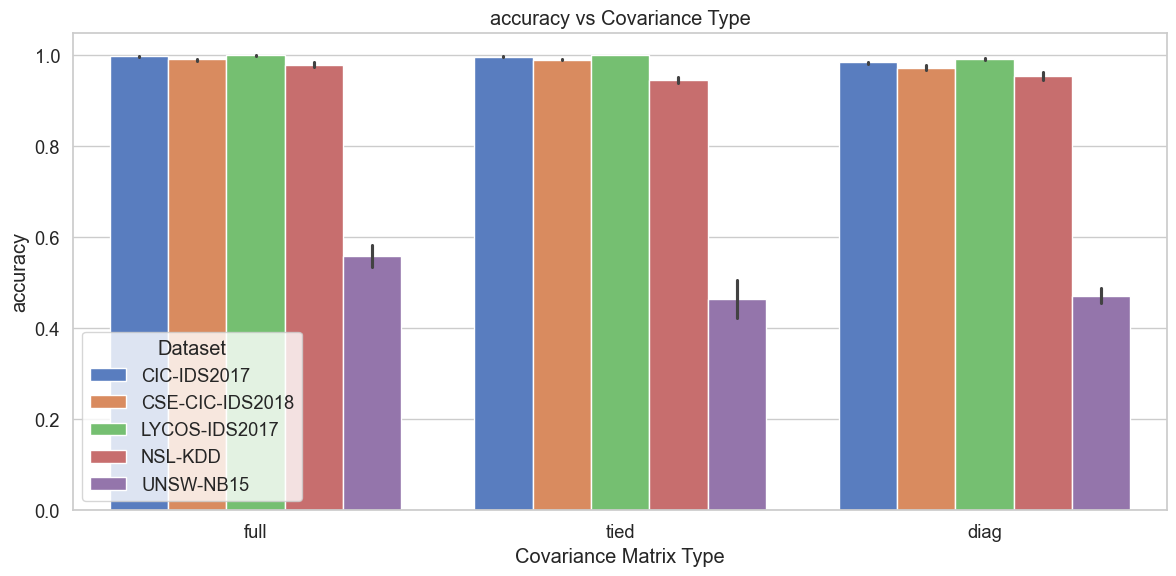

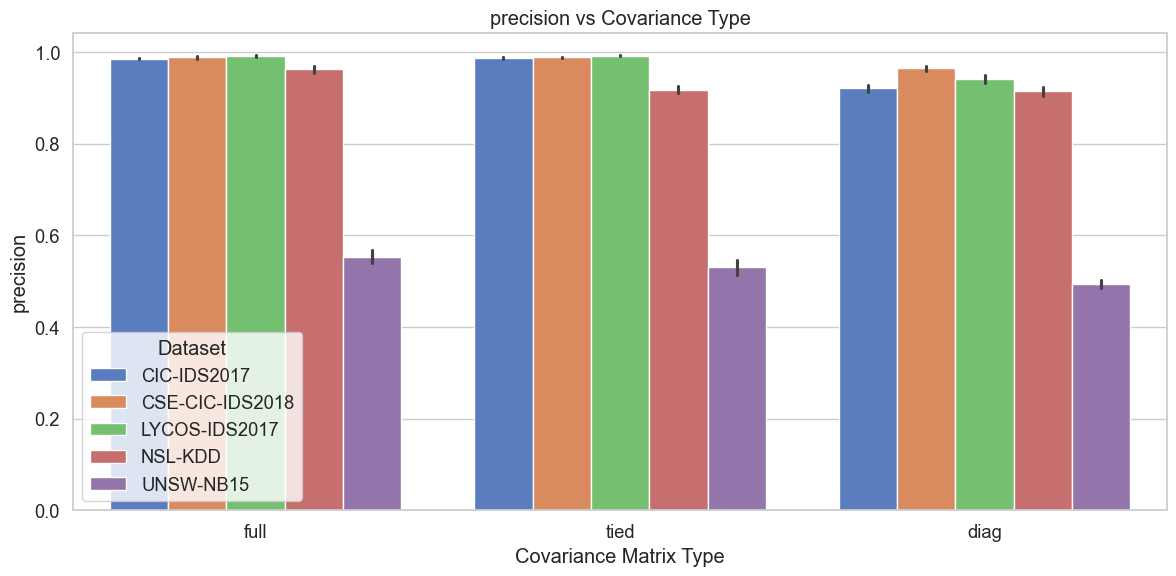

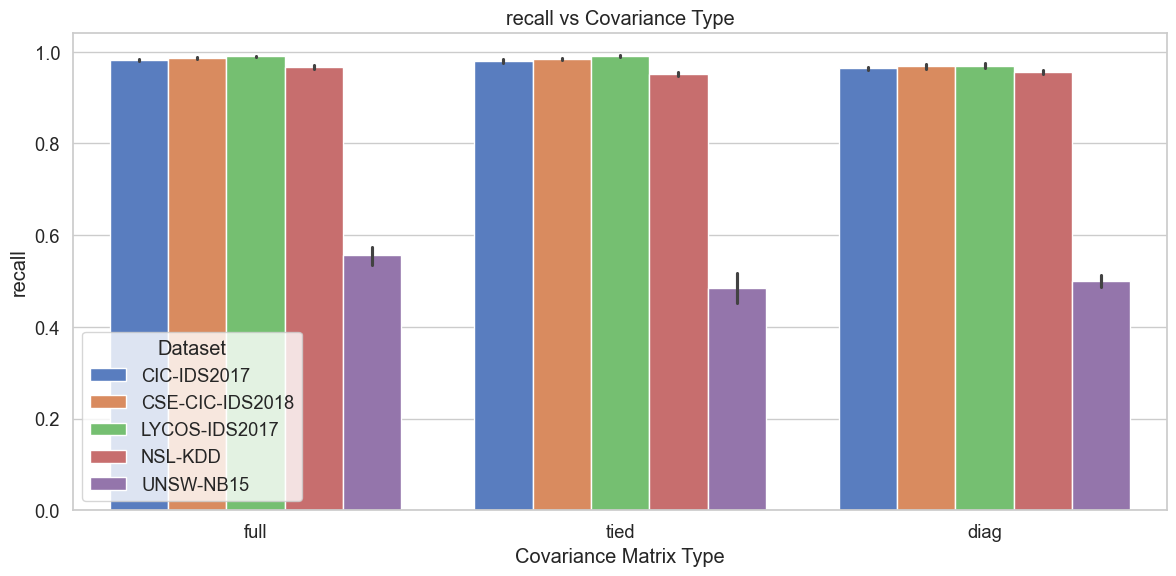

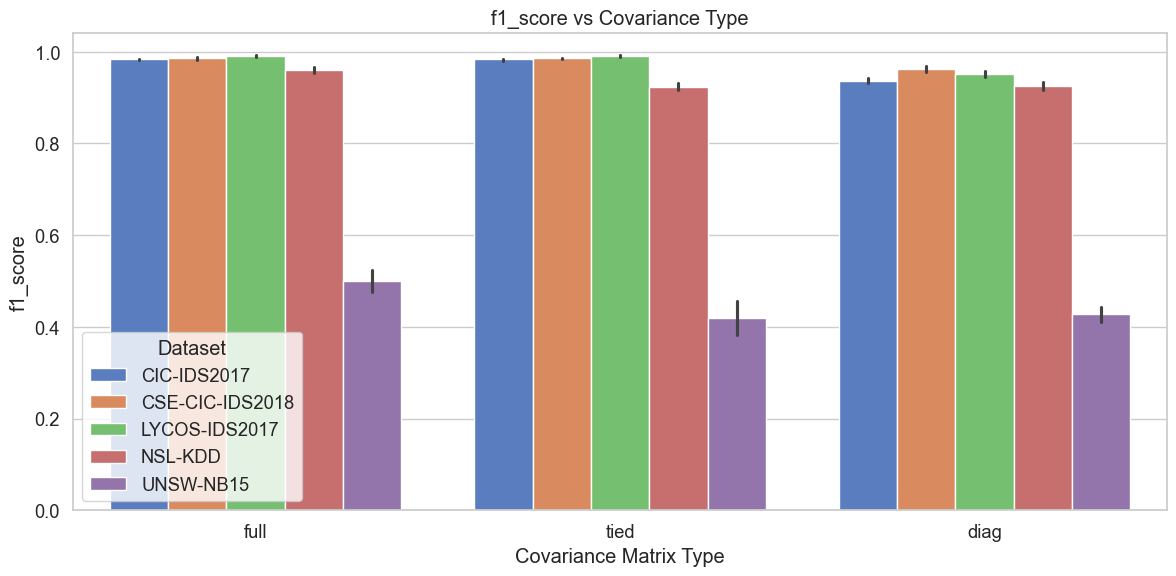

In [16]:
for metric in metrics:
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_clean, x="covariance_type", y=metric, hue="dataset", errorbar=('ci', 95))
    plt.title(f"{metric} vs Covariance Type")
    plt.xlabel("Covariance Matrix Type")
    plt.ylabel(metric)
    plt.legend(title="Dataset")
    plt.tight_layout()
    plt.show()

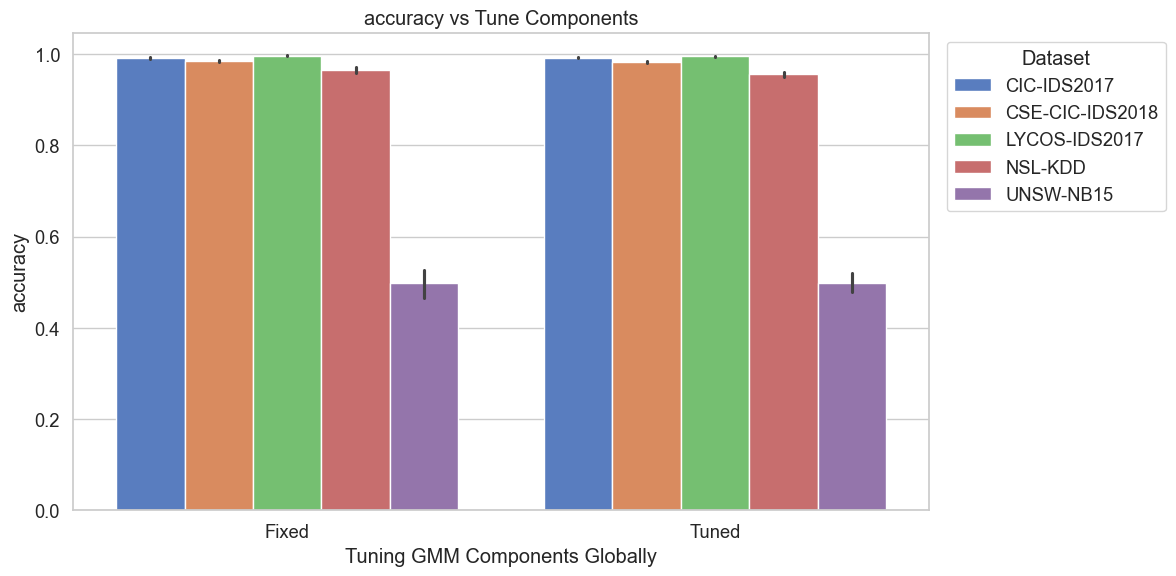

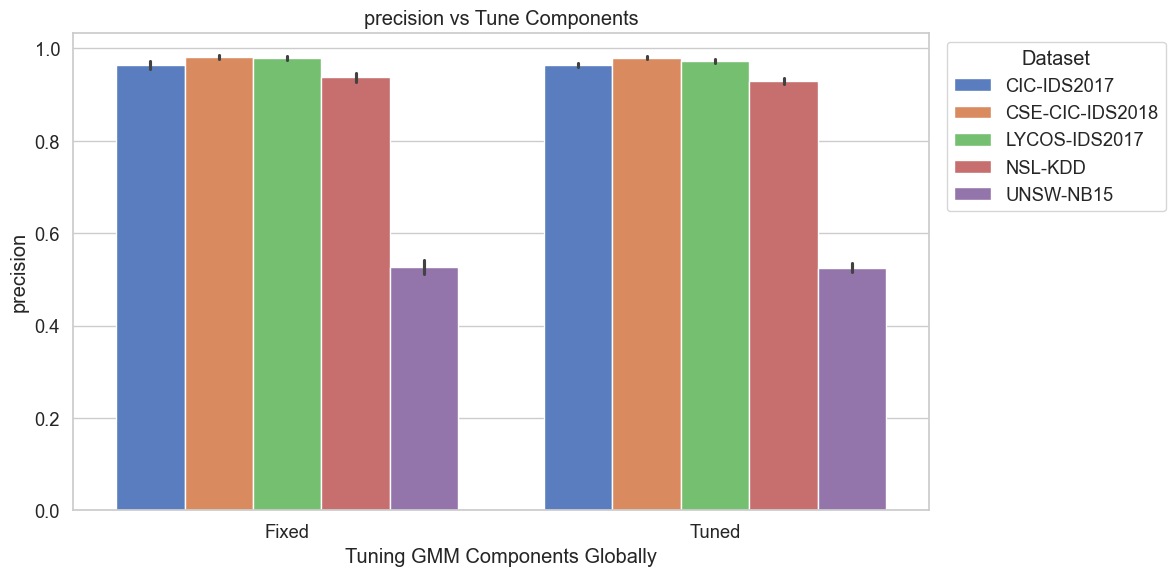

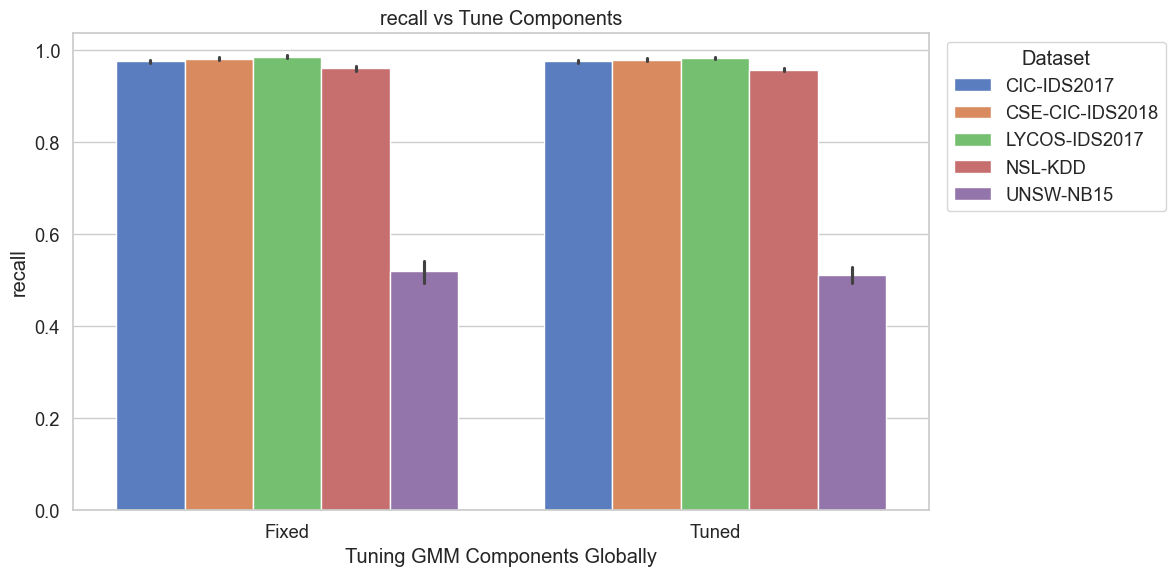

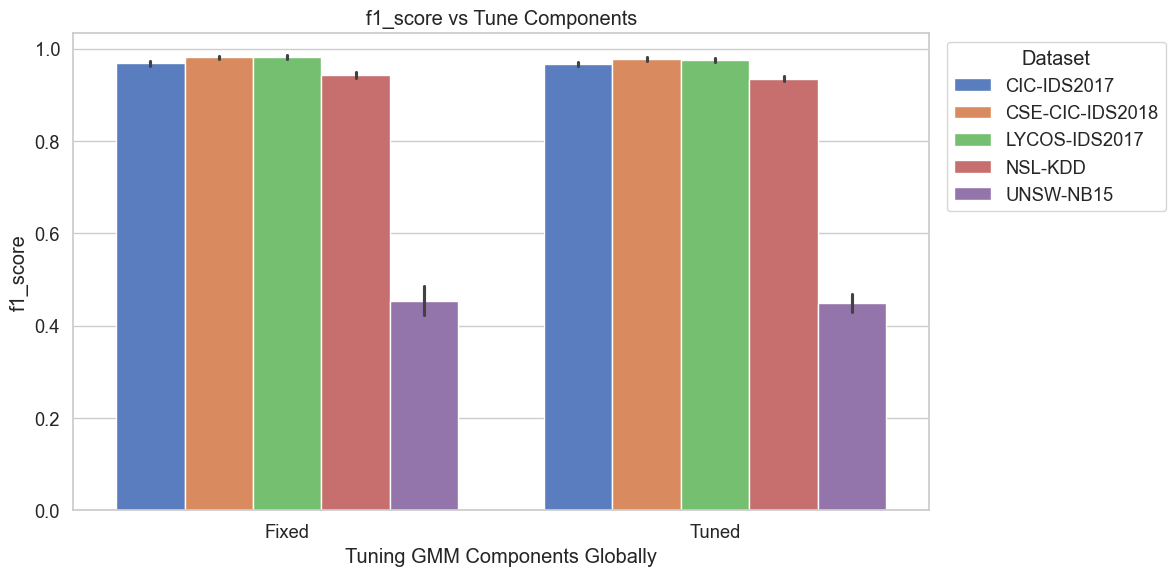

In [17]:
for metric in metrics:
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_clean, x="tune_components", y=metric, hue="dataset", errorbar=('ci', 95))
    plt.title(f"{metric} vs Tune Components")
    plt.xlabel("Tuning GMM Components Globally")
    plt.ylabel(metric)
    plt.xticks([0, 1], ["Fixed", "Tuned"])
    plt.legend(title="Dataset", bbox_to_anchor=(1.01, 1))
    plt.tight_layout()
    plt.show()

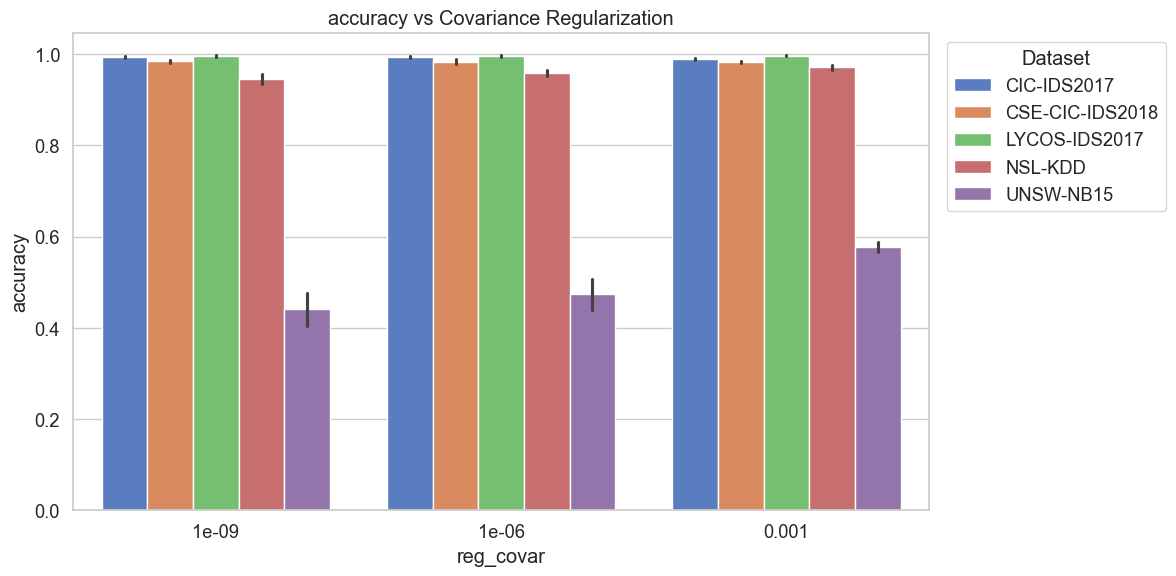

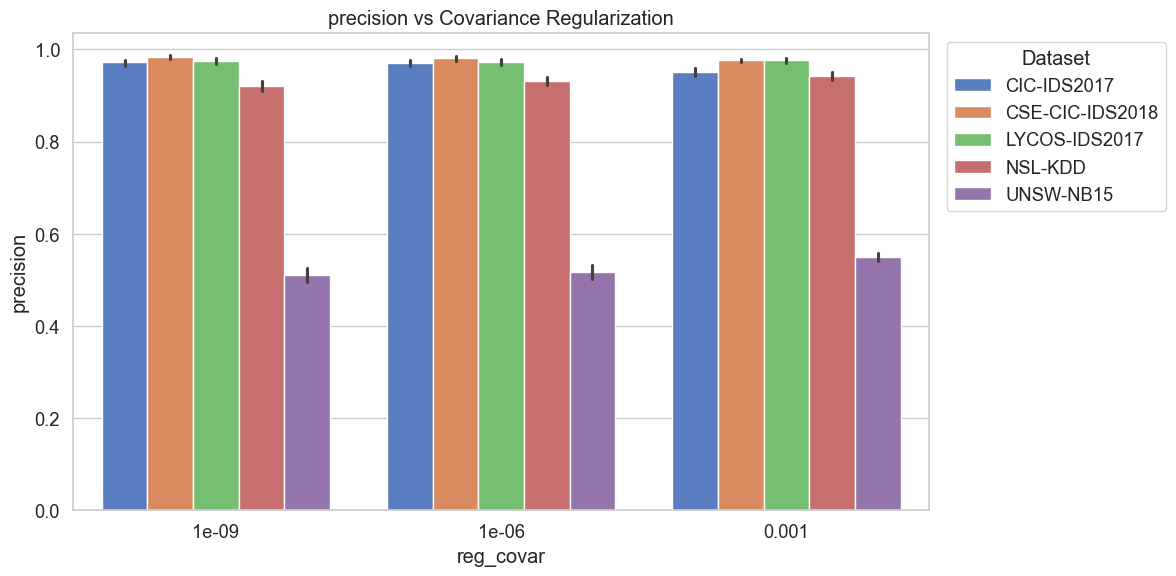

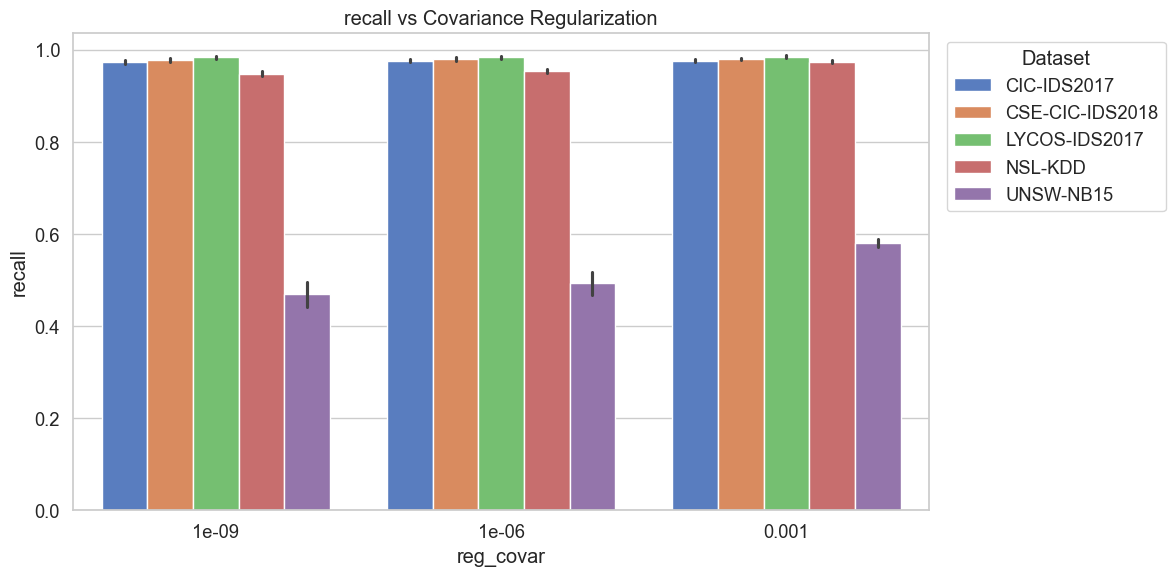

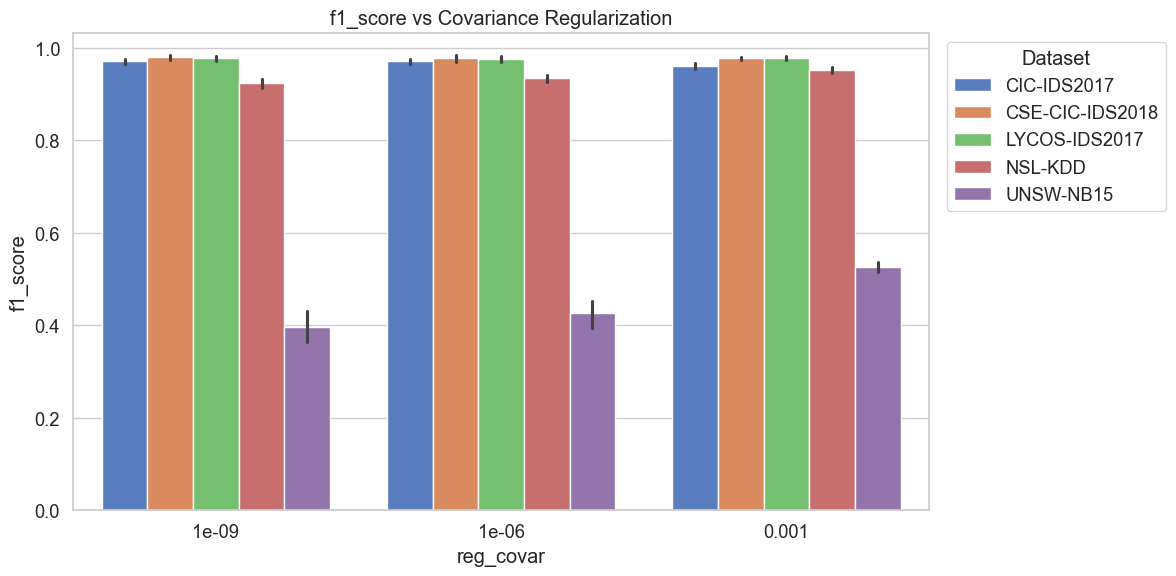

In [18]:
for metric in metrics:
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_clean, x="reg_covar", y=metric, hue="dataset", errorbar=('ci', 95))
    plt.title(f"{metric} vs Covariance Regularization")
    plt.xlabel("reg_covar")
    plt.ylabel(metric)
    plt.legend(title="Dataset", bbox_to_anchor=(1.01, 1))
    plt.tight_layout()
    plt.show()

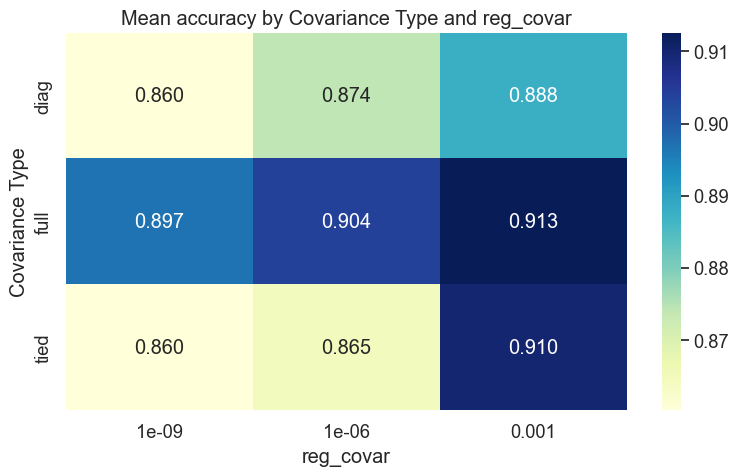

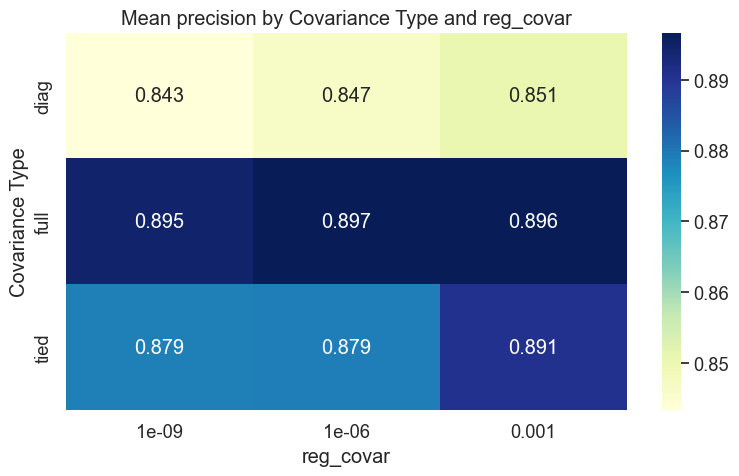

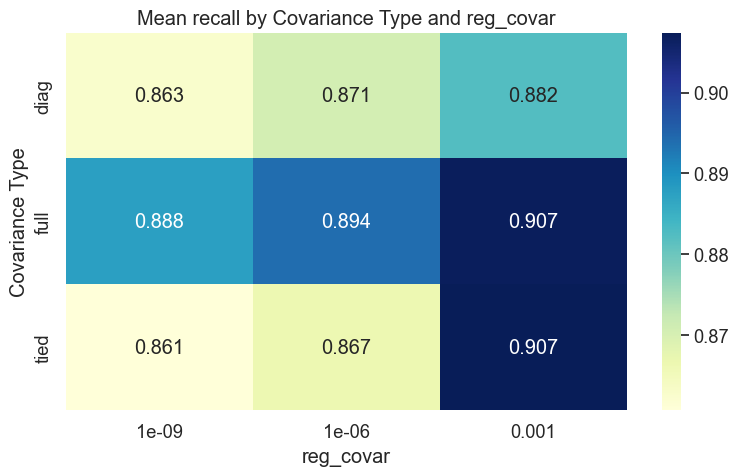

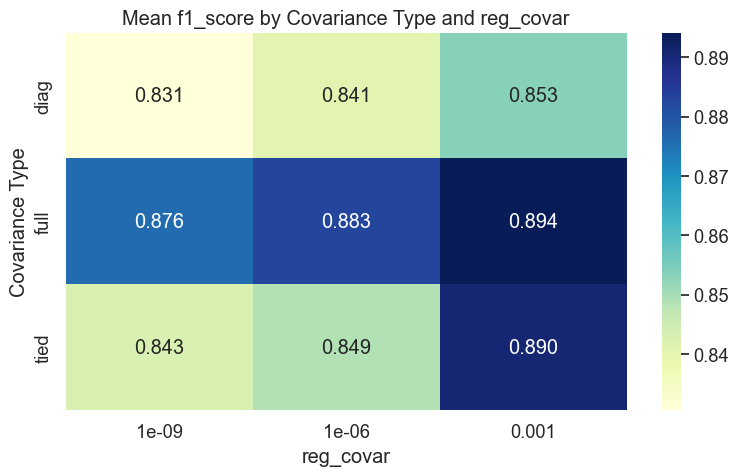

In [19]:
for metric in metrics:
    pivot = df_clean.groupby(["covariance_type", "reg_covar"])[metric].mean().unstack()
    plt.figure(figsize=(8, 5))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="YlGnBu")
    plt.title(f"Mean {metric} by Covariance Type and reg_covar")
    plt.xlabel("reg_covar")
    plt.ylabel("Covariance Type")
    plt.tight_layout()
    plt.show()

In [20]:
# Create rows for best and worst summaries
rows_best = []
rows_worst = []

for metric in metrics:
    for dataset in df_clean["dataset"].unique():
        subset = df_clean[df_clean["dataset"] == dataset]

        best = subset.loc[subset[metric].idxmax()]
        worst = subset.loc[subset[metric].idxmin()]

        rows_best.append({
            "dataset": dataset,
            "metric": metric,
            "covariance_type": best["covariance_type"],
            "reg_covar": best["reg_covar"],
            "selection_metric": best["selection_metric"],
            "tune_components": best["tune_components"],
            "score": best[metric]
        })

        rows_worst.append({
            "dataset": dataset,
            "metric": metric,
            "covariance_type": worst["covariance_type"],
            "reg_covar": worst["reg_covar"],
            "selection_metric": worst["selection_metric"],
            "tune_components": worst["tune_components"],
            "score": worst[metric]
        })

# Create DataFrames
df_best_configs = pd.DataFrame(rows_best)
df_worst_configs = pd.DataFrame(rows_worst)

# Display them

print("--- Best scores: ---")
display(df_best_configs.sort_values(["metric", "dataset"]))

print("\n\n --- Worst scores: ---")
display(df_worst_configs.sort_values(["metric", "dataset"]))

--- Best scores: ---


,dataset,metric,covariance_type,reg_covar,selection_metric,tune_components,score
0,CIC-IDS2017,accuracy,full,1.000000e-09,aic,True,0.999128
1,CSE-CIC-IDS2018,accuracy,full,1.000000e-06,aic,True,0.996797
2,LYCOS-IDS2017,accuracy,full,1.000000e-09,aic,True,0.999637
3,NSL-KDD,accuracy,full,1.000000e-03,aic,True,0.996327
4,UNSW-NB15,accuracy,full,1.000000e-09,accuracy,True,0.733231
15,CIC-IDS2017,f1_score,full,1.000000e-09,aic,True,0.995351
16,CSE-CIC-IDS2018,f1_score,full,1.000000e-06,aic,True,0.996191
17,LYCOS-IDS2017,f1_score,full,1.000000e-09,aic,True,0.997162
18,NSL-KDD,f1_score,full,1.000000e-03,aic,True,0.989637
19,UNSW-NB15,f1_score,full,1.000000e-06,accuracy,True,0.662414




 --- Worst scores: ---


,dataset,metric,covariance_type,reg_covar,selection_metric,tune_components,score
0,CIC-IDS2017,accuracy,diag,1.000000e-03,aic,True,0.952753
1,CSE-CIC-IDS2018,accuracy,diag,1.000000e-06,aic,True,0.828100
2,LYCOS-IDS2017,accuracy,diag,1.000000e-06,aic,True,0.966846
3,NSL-KDD,accuracy,diag,1.000000e-09,aic,True,0.634193
4,UNSW-NB15,accuracy,diag,1.000000e-09,aic,True,0.187592
15,CIC-IDS2017,f1_score,diag,1.000000e-03,aic,True,0.863696
16,CSE-CIC-IDS2018,f1_score,diag,1.000000e-06,aic,True,0.775390
17,LYCOS-IDS2017,f1_score,diag,1.000000e-06,aic,True,0.853056
18,NSL-KDD,f1_score,diag,1.000000e-09,aic,True,0.743454
19,UNSW-NB15,f1_score,diag,1.000000e-09,aic,True,0.146773


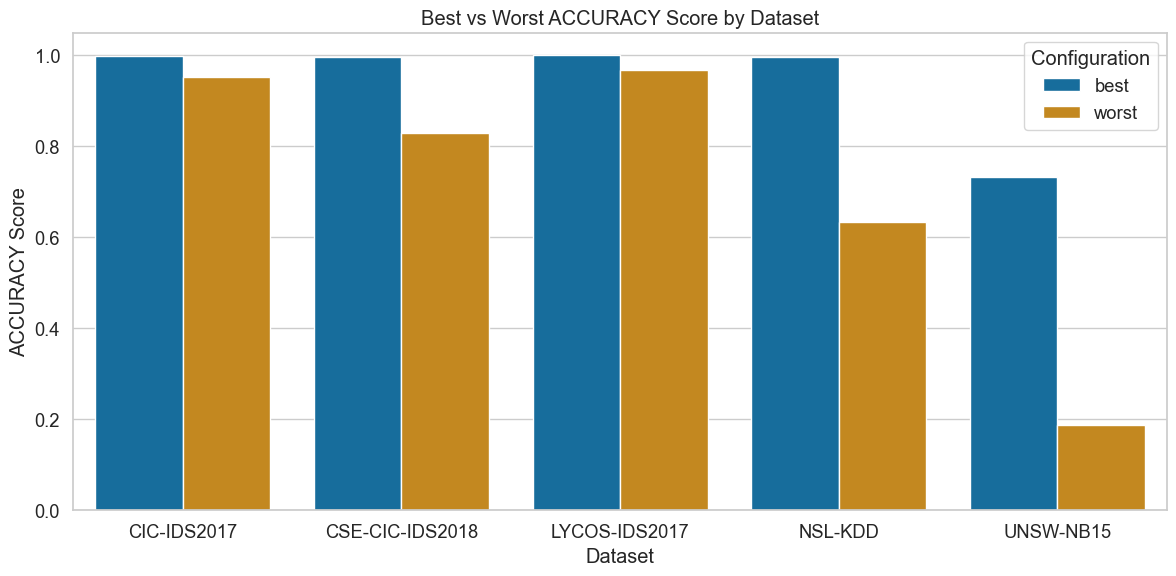

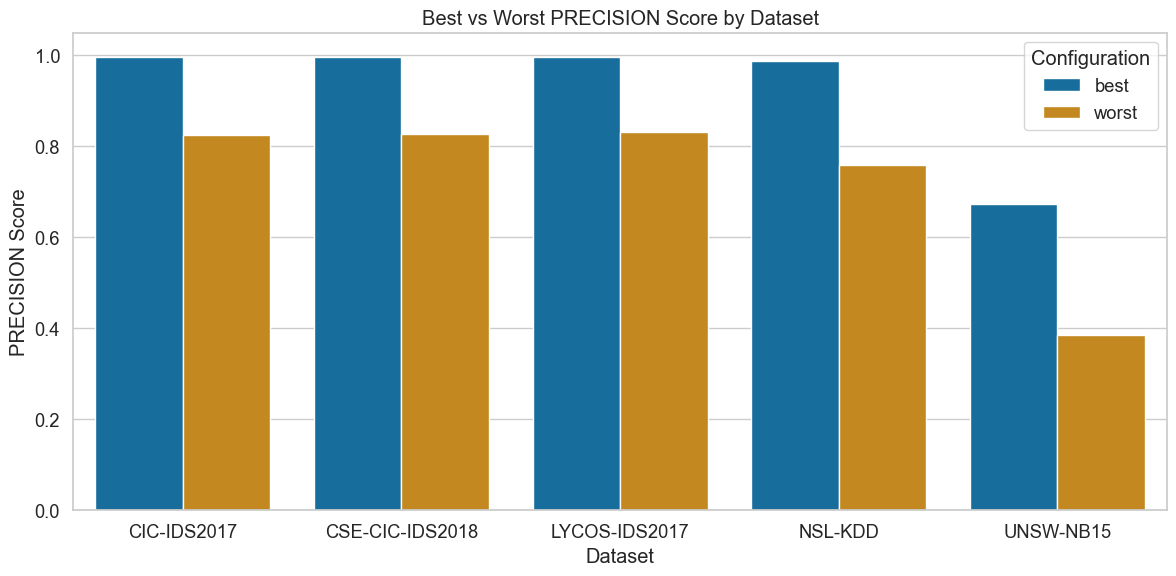

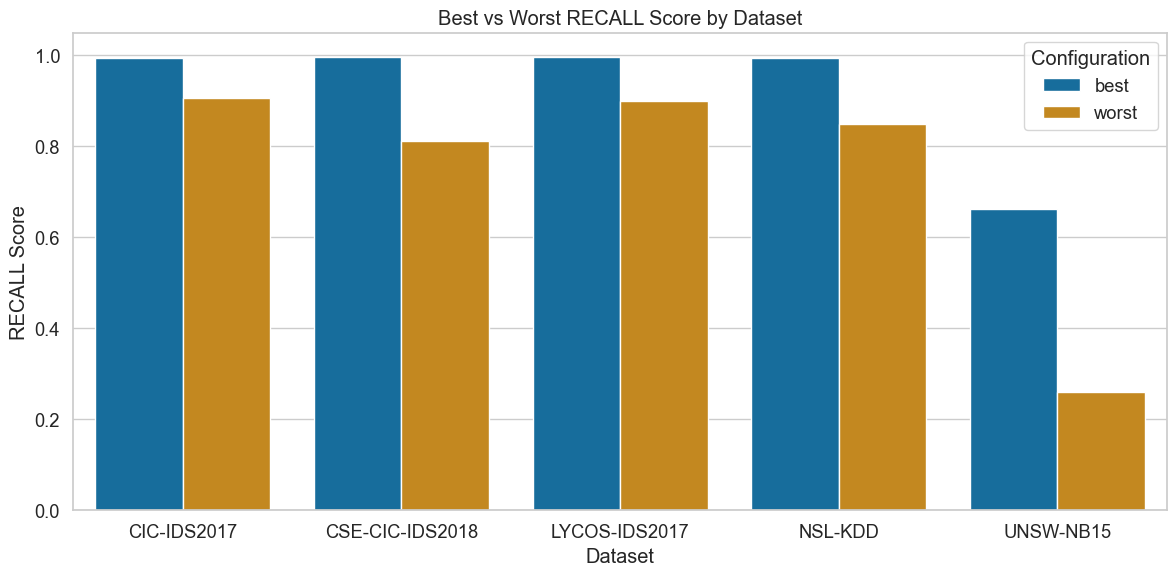

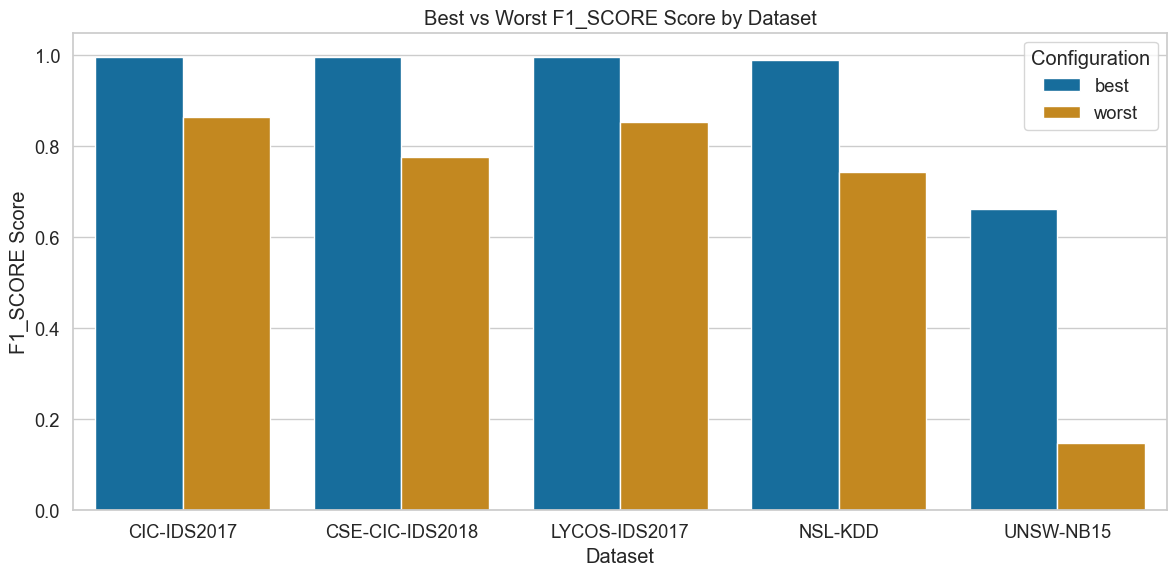

In [21]:
# Merge best and worst configs into one DataFrame with a 'type' column
df_best_configs["type"] = "best"
df_worst_configs["type"] = "worst"
df_summary = pd.concat([df_best_configs, df_worst_configs], ignore_index=True)

# Plot for each metric
sns.set(style="whitegrid", palette="colorblind", font_scale=1.2)

for metric in df_summary["metric"].unique():
    plt.figure(figsize=(12, 6))
    data = df_summary[df_summary["metric"] == metric]

    sns.barplot(data=data, x="dataset", y="score", hue="type")
    plt.title(f"Best vs Worst {metric.upper()} Score by Dataset")
    plt.ylabel(f"{metric.upper()} Score")
    plt.xlabel("Dataset")
    plt.legend(title="Configuration")
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()